# Аналіз згенерованого щільного датасету

Завантажуємо готовий dataset і аналізуємо:
- Перші 50 записів (Sample 0 має бути експеримент)
- Скільки унікальних значень по кожному параметру
- Діапазони параметрів
- Покриття довкола експерименту

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from pathlib import Path
from model_common import PARAM_NAMES

# Експериментальні параметри для порівняння
EXPERIMENT_PARAMS = {
    'Dmax1': 0.008094,
    'D01': 0.000943,
    'L1': 5200e-8,
    'Rp1': 3500e-8,
    'D02': 0.00255,
    'L2': 3000e-8,
    'Rp2': -50e-8,
}

center_arr = np.array([EXPERIMENT_PARAMS[p] for p in PARAM_NAMES])

print(f"Expected experimental parameters:")
for i, param in enumerate(PARAM_NAMES):
    print(f"  {param:<10}: {center_arr[i]:.6e}")

Expected experimental parameters:
  Dmax1     : 8.094000e-03
  D01       : 9.430000e-04
  L1        : 5.200000e-05
  Rp1       : 3.500000e-05
  D02       : 2.550000e-03
  L2        : 3.000000e-05
  Rp2       : -5.000000e-07


## 📂 Завантаження датасету

In [52]:
# Шлях до датасету (змінити на свій!)
DATASET_PATH = "datasets/dataset_10000_dl100_targeted.pkl"

# Або знайти автоматично найновіший
dataset_files = list(Path("datasets").glob("dataset_*_dense_*.pkl"))
if dataset_files and not DATASET_PATH:
    # Sort by modification time
    dataset_files.sort(key=lambda x: x.stat().st_mtime, reverse=True)
    DATASET_PATH = str(dataset_files[0])
    print(f"\n📁 Найновіший датасет: {DATASET_PATH}")
else:
    print(f"\n⚠️  Датасет не знайдено! Згенеруйте спочатку:")
    print(f"    python generate_targeted_dataset.py --n-samples 10000")

# Завантаження
print(f"\nЗавантаження: {DATASET_PATH}...")
with open(DATASET_PATH, 'rb') as f:
    data = pickle.load(f)

X = data['X']
Y = data['Y']
gen_params = data.get('generation_params', {})

print(f"\n✅ Завантажено:")
print(f"   X shape: {X.shape} (parameters)")
print(f"   Y shape: {Y.shape} (curves)")
print(f"   File size: {Path(DATASET_PATH).stat().st_size / (1024**2):.1f} MB")

# Show generation params
if gen_params:
    print(f"\n📊 Параметри генерації:")
    for key, value in gen_params.items():
        if key not in ['experiment_params', 'local_ranges', 'steps']:
            print(f"   {key}: {value}")


⚠️  Датасет не знайдено! Згенеруйте спочатку:
    python generate_targeted_dataset.py --n-samples 10000

Завантаження: datasets/dataset_10000_dl100_targeted.pkl...

✅ Завантажено:
   X shape: (10000, 7) (parameters)
   Y shape: (10000, 701) (curves)
   File size: 27.0 MB

📊 Параметри генерації:
   n_samples: 10000
   dl: 1e-06
   range_pct: 20
   step_pct: 1
   method: Dense grid around experimental parameters
   first_sample: EXPERIMENTAL PARAMETERS (always X[0])
   timestamp: 20251109_000550


## ✅ Перевірка: чи Sample 0 = експеримент?

In [53]:
print("\n" + "="*80)
print("ПЕРЕВІРКА ПЕРШОГО ЗАПИСУ")
print("="*80)

# Check if first sample is experiment
is_experiment = np.allclose(X[0], center_arr, rtol=1e-10)

print(f"\nSample 0 vs Experiment:")
print(f"{'Parameter':<10} {'Sample 0':>15} {'Experiment':>15} {'Match':>10}")
print("-"*80)

for i, param in enumerate(PARAM_NAMES):
    match = "✅" if np.isclose(X[0, i], center_arr[i], rtol=1e-10) else "❌"
    print(f"{param:<10} {X[0, i]:>15.6e} {center_arr[i]:>15.6e} {match:>10}")

if is_experiment:
    print(f"\n✅ PERFECT! Sample 0 = experimental parameters")
else:
    max_diff = np.abs(X[0] - center_arr).max()
    print(f"\n❌ WARNING: Sample 0 ≠ experiment")
    print(f"   Max difference: {max_diff:.6e}")


ПЕРЕВІРКА ПЕРШОГО ЗАПИСУ

Sample 0 vs Experiment:
Parameter         Sample 0      Experiment      Match
--------------------------------------------------------------------------------
Dmax1         8.094000e-03    8.094000e-03          ✅
D01           9.430000e-04    9.430000e-04          ✅
L1            5.200000e-05    5.200000e-05          ✅
Rp1           3.500000e-05    3.500000e-05          ✅
D02           2.550000e-03    2.550000e-03          ✅
L2            3.000000e-05    3.000000e-05          ✅
Rp2          -5.000000e-07   -5.000000e-07          ✅

✅ PERFECT! Sample 0 = experimental parameters


## 📋 Перші 50 записів

In [54]:
# Create DataFrame
df = pd.DataFrame(X[:50], columns=PARAM_NAMES)
df.index.name = 'Sample'

# Format scientific notation
pd.options.display.float_format = '{:.6e}'.format

print("\n" + "="*100)
print("ПЕРШІ 50 ЗАПИСІВ (Sample 0 = EXPERIMENT)")
print("="*100)

print(df)

# Export to CSV for easier viewing
# csv_path = DATASET_PATH.replace('.pkl', '_first50.csv')
# df.to_csv(csv_path)
# print(f"\n💾 Збережено у CSV: {csv_path}")


ПЕРШІ 50 ЗАПИСІВ (Sample 0 = EXPERIMENT)
              Dmax1          D01           L1          Rp1          D02  \
Sample                                                                    
0      8.094000e-03 9.430000e-04 5.200000e-05 3.500000e-05 2.550000e-03   
1      9.389040e-03 1.063704e-03 5.865600e-05 3.892000e-05 2.264400e-03   
2      8.255880e-03 1.063704e-03 6.198400e-05 3.164000e-05 3.049800e-03   
3      9.065280e-03 1.033528e-03 5.428800e-05 3.486000e-05 2.886600e-03   
4      8.741520e-03 9.128240e-04 4.929600e-05 2.842000e-05 2.539800e-03   
5      7.090344e-03 8.222960e-04 5.865600e-05 3.976000e-05 2.682600e-03   
6      7.932120e-03 7.694880e-04 5.886400e-05 3.346000e-05 2.743800e-03   
7      7.673112e-03 7.958920e-04 5.220800e-05 2.968000e-05 2.570400e-03   
8      7.122720e-03 9.807200e-04 5.324800e-05 3.318000e-05 2.070600e-03   
9      7.964496e-03 7.958920e-04 5.387200e-05 2.940000e-05 2.560200e-03   
10     6.798960e-03 7.883480e-04 4.160000e-05 3.990000e-05

## 📊 Статистика по параметрах

In [55]:
print("\n" + "="*80)
print("СТАТИСТИКА ПО ВСІХ ПАРАМЕТРАХ")
print("="*80)

print(f"\n{'Parameter':<10} {'Experiment':>12} {'Mean':>12} {'Std':>12} {'Min':>12} {'Max':>12} {'Range':>12}")
print("-"*90)

for i, param in enumerate(PARAM_NAMES):
    exp_val = center_arr[i]
    mean_val = X[:, i].mean()
    std_val = X[:, i].std()
    min_val = X[:, i].min()
    max_val = X[:, i].max()
    range_val = max_val - min_val
    
    print(f"{param:<10} {exp_val:>12.6e} {mean_val:>12.6e} {std_val:>12.6e} "
          f"{min_val:>12.6e} {max_val:>12.6e} {range_val:>12.6e}")

# Range as % of center
print(f"\n📏 Діапазон як % від центру:")
for i, param in enumerate(PARAM_NAMES):
    exp_val = center_arr[i]
    range_val = X[:, i].max() - X[:, i].min()
    if exp_val != 0:
        pct = 100 * range_val / abs(exp_val)
    else:
        pct = 0
    print(f"   {param:<10}: {pct:>6.2f}%")


СТАТИСТИКА ПО ВСІХ ПАРАМЕТРАХ

Parameter    Experiment         Mean          Std          Min          Max        Range
------------------------------------------------------------------------------------------
Dmax1      8.094000e-03 8.102930e-03 9.466708e-04 6.475200e-03 9.712800e-03 3.237600e-03
D01        9.430000e-04 9.422097e-04 1.097964e-04 7.544000e-04 1.131600e-03 3.772000e-04
L1         5.200000e-05 5.195166e-05 6.089957e-06 4.160000e-05 6.240000e-05 2.080000e-05
Rp1        3.500000e-05 3.501270e-05 4.101087e-06 2.800000e-05 4.200000e-05 1.400000e-05
D02        2.550000e-03 2.556377e-03 2.971009e-04 2.040000e-03 3.060000e-03 1.020000e-03
L2         3.000000e-05 2.998229e-05 3.495908e-06 2.400000e-05 3.600000e-05 1.200000e-05
Rp2        -5.000000e-07 -4.989968e-07 5.796199e-08 -6.000000e-07 -4.000000e-07 2.000000e-07

📏 Діапазон як % від центру:
   Dmax1     :  40.00%
   D01       :  40.00%
   L1        :  40.00%
   Rp1       :  40.00%
   D02       :  40.00%
   L2        :  4

## 🔢 Унікальні значення

In [56]:
print("\n" + "="*80)
print("УНІКАЛЬНІ ЗНАЧЕННЯ ПО ПАРАМЕТРАХ")
print("="*80)

print(f"\n{'Parameter':<10} {'N_unique':>10} {'Total':>10} {'Coverage':>10}")
print("-"*50)

for i, param in enumerate(PARAM_NAMES):
    n_unique = len(np.unique(X[:, i]))
    n_total = len(X)
    coverage = 100 * n_unique / n_total
    
    print(f"{param:<10} {n_unique:>10} {n_total:>10} {coverage:>9.1f}%")

print(f"\n💡 Пояснення:")
print(f"   - N_unique: скільки різних значень цього параметра")
print(f"   - Total: загальна кількість записів")
print(f"   - Coverage: відсоток унікальних значень")
print(f"\n   Низький coverage = багато повторів (добре для щільної сітки!)")


УНІКАЛЬНІ ЗНАЧЕННЯ ПО ПАРАМЕТРАХ

Parameter    N_unique      Total   Coverage
--------------------------------------------------
Dmax1             101      10000       1.0%
D01               101      10000       1.0%
L1                101      10000       1.0%
Rp1               101      10000       1.0%
D02               101      10000       1.0%
L2                101      10000       1.0%
Rp2               101      10000       1.0%

💡 Пояснення:
   - N_unique: скільки різних значень цього параметра
   - Total: загальна кількість записів
   - Coverage: відсоток унікальних значень

   Низький coverage = багато повторів (добре для щільної сітки!)


## 📈 Візуалізація розподілів


✅ Saved: datasets/dataset_10000_dl100_targeted_distribution.png


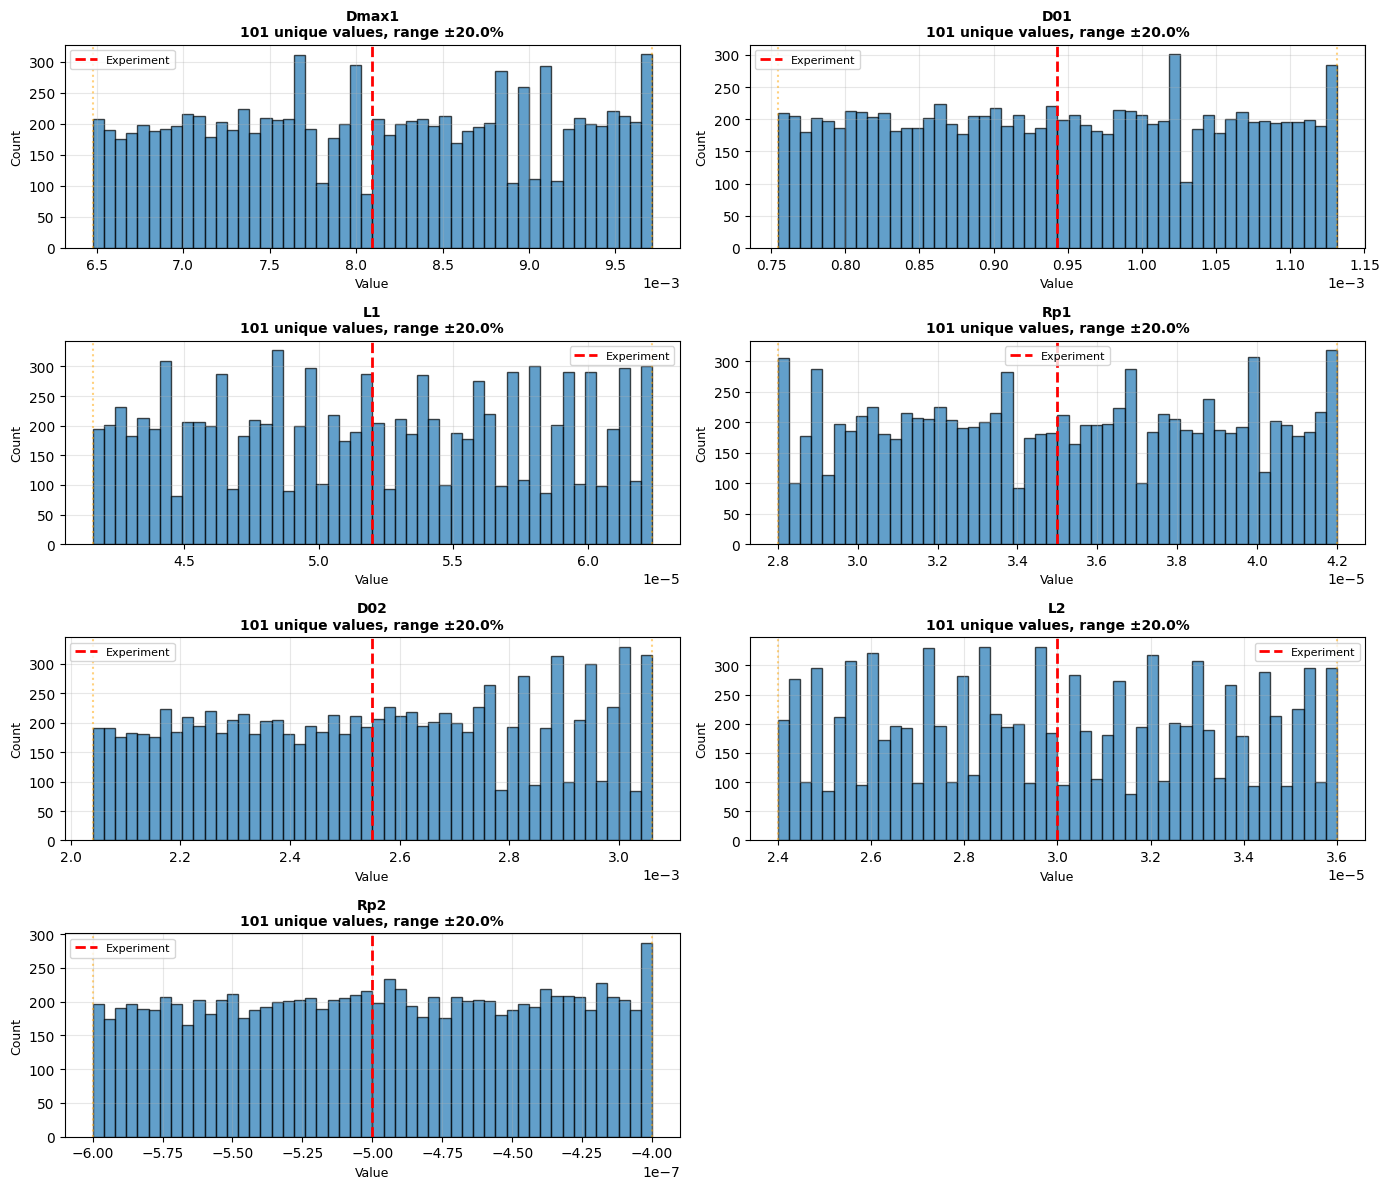

In [57]:
fig, axes = plt.subplots(4, 2, figsize=(14, 12))
axes = axes.flatten()

for i, param in enumerate(PARAM_NAMES):
    ax = axes[i]
    
    # Histogram
    n_unique = len(np.unique(X[:, i]))
    ax.hist(X[:, i], bins=min(50, n_unique), alpha=0.7, edgecolor='black')
    
    # Mark experiment
    ax.axvline(center_arr[i], color='red', linestyle='--', linewidth=2, label='Experiment')
    
    # Mark range
    min_val = X[:, i].min()
    max_val = X[:, i].max()
    ax.axvline(min_val, color='orange', linestyle=':', alpha=0.5)
    ax.axvline(max_val, color='orange', linestyle=':', alpha=0.5)
    
    # Title with stats
    range_pct = 100 * (max_val - min_val) / abs(center_arr[i]) if center_arr[i] != 0 else 0
    ax.set_title(f'{param}\n{n_unique} unique values, range ±{range_pct/2:.1f}%', 
                 fontsize=10, fontweight='bold')
    ax.set_xlabel('Value', fontsize=9)
    ax.set_ylabel('Count', fontsize=9)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))

# Hide empty subplot
axes[7].axis('off')

plt.tight_layout()
png_path = DATASET_PATH.replace('.pkl', '_distribution.png')
# plt.savefig(png_path, dpi=150, bbox_inches='tight')
print(f"\n✅ Saved: {png_path}")
plt.show()

## 🎯 Distance to experiment

In [58]:
# Get local ranges from generation params if available
if 'local_ranges' in gen_params:
    local_ranges = gen_params['local_ranges']
else:
    # Calculate from data
    local_ranges = {}
    for i, param in enumerate(PARAM_NAMES):
        local_ranges[param] = (X[:, i].min(), X[:, i].max())

# Normalize
X_norm = np.zeros_like(X)
center_norm = np.zeros_like(center_arr)

for i, param in enumerate(PARAM_NAMES):
    min_val, max_val = local_ranges[param]
    range_width = max_val - min_val
    if range_width > 0:
        X_norm[:, i] = (X[:, i] - min_val) / range_width
        center_norm[i] = (center_arr[i] - min_val) / range_width
    else:
        X_norm[:, i] = 0.5
        center_norm[i] = 0.5

distances = np.linalg.norm(X_norm - center_norm, axis=1)

print("\n" + "="*80)
print("DISTANCE TO EXPERIMENT (normalized space)")
print("="*80)

print(f"\nMin distance:    {distances.min():.6f} (sample {distances.argmin()})")
print(f"Max distance:    {distances.max():.6f}")
print(f"Mean distance:   {distances.mean():.6f}")
print(f"Median distance: {np.median(distances):.6f}")

print(f"\nSamples within distance thresholds:")
for threshold in [0.05, 0.10, 0.15, 0.20, 0.30, 0.50]:
    count = np.sum(distances <= threshold)
    pct = 100 * count / len(X)
    print(f"   ≤ {threshold:.2f}: {count:>6,} ({pct:>5.1f}%)")

# Check sample 0
print(f"\n⭐ Sample 0 distance: {distances[0]:.10f}")
if distances[0] < 1e-6:
    print(f"   ✅ Perfect! Sample 0 is exactly the experiment")
else:
    print(f"   ⚠️  Sample 0 has non-zero distance!")


DISTANCE TO EXPERIMENT (normalized space)

Min distance:    0.000000 (sample 0)
Max distance:    1.172263
Mean distance:   0.759886
Median distance: 0.766681

Samples within distance thresholds:
   ≤ 0.05:      1 (  0.0%)
   ≤ 0.10:      1 (  0.0%)
   ≤ 0.15:      1 (  0.0%)
   ≤ 0.20:      1 (  0.0%)
   ≤ 0.30:     11 (  0.1%)
   ≤ 0.50:    344 (  3.4%)

⭐ Sample 0 distance: 0.0000003010
   ✅ Perfect! Sample 0 is exactly the experiment


## 📊 Distance distribution plot


✅ Saved: datasets/dataset_10000_dl100_targeted_distances.png


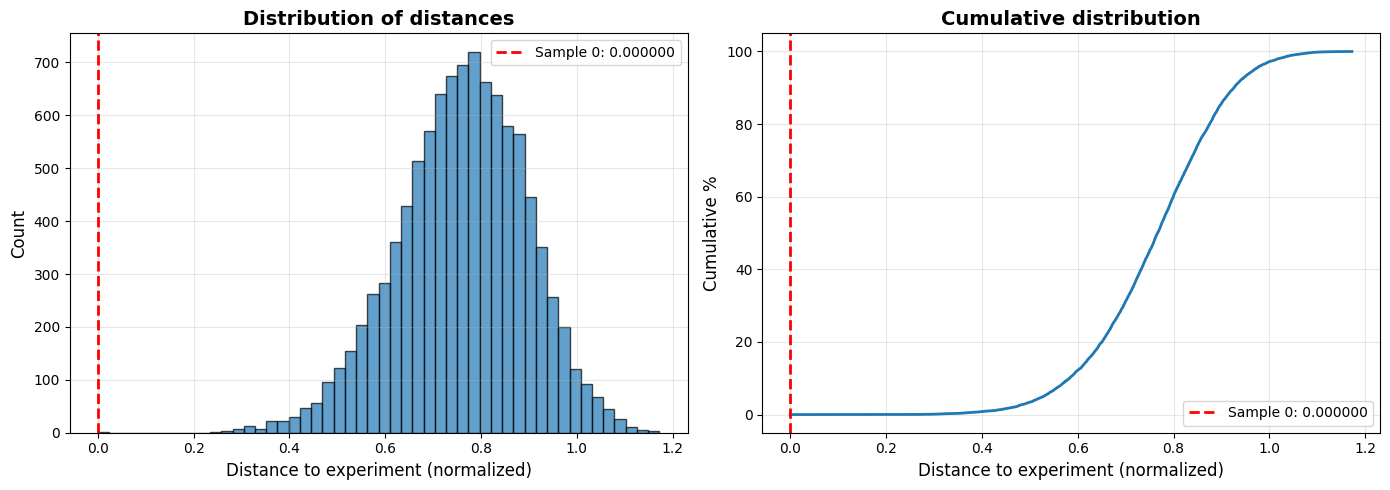

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(distances, bins=50, alpha=0.7, edgecolor='black')
axes[0].axvline(distances[0], color='red', linestyle='--', linewidth=2, 
                label=f'Sample 0: {distances[0]:.6f}')
axes[0].set_xlabel('Distance to experiment (normalized)', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Distribution of distances', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Cumulative
sorted_distances = np.sort(distances)
cumulative = np.arange(1, len(distances) + 1) / len(distances) * 100
axes[1].plot(sorted_distances, cumulative, linewidth=2)
axes[1].axvline(distances[0], color='red', linestyle='--', linewidth=2, 
                label=f'Sample 0: {distances[0]:.6f}')
axes[1].set_xlabel('Distance to experiment (normalized)', fontsize=12)
axes[1].set_ylabel('Cumulative %', fontsize=12)
axes[1].set_title('Cumulative distribution', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
png_path = DATASET_PATH.replace('.pkl', '_distances.png')
# plt.savefig(png_path, dpi=150, bbox_inches='tight')
print(f"\n✅ Saved: {png_path}")
plt.show()

## 📋 Підсумок

In [60]:
print("\n" + "="*80)
print("ПІДСУМОК АНАЛІЗУ")
print("="*80)

print(f"\n📂 Dataset: {Path(DATASET_PATH).name}")
print(f"   Samples: {len(X):,}")
print(f"   Curves:  {len(Y):,} x {Y.shape[1]} points")
print(f"   Size:    {Path(DATASET_PATH).stat().st_size / (1024**2):.1f} MB")

print(f"\n✅ Sample 0 check:")
if np.allclose(X[0], center_arr, rtol=1e-10):
    print(f"   ✅ PERFECT: Sample 0 = experimental parameters")
else:
    print(f"   ❌ WARNING: Sample 0 ≠ experimental parameters")

print(f"\n📊 Unique values:")
for i, param in enumerate(PARAM_NAMES):
    n_unique = len(np.unique(X[:, i]))
    print(f"   {param:<10}: {n_unique:>4} unique values")

print(f"\n🎯 Coverage around experiment:")
within_10pct = np.sum(distances <= 0.10)
within_20pct = np.sum(distances <= 0.20)
print(f"   Within 10% normalized distance: {within_10pct:>6,} ({100*within_10pct/len(X):>5.1f}%)")
print(f"   Within 20% normalized distance: {within_20pct:>6,} ({100*within_20pct/len(X):>5.1f}%)")

if 'range_pct' in gen_params and 'step_pct' in gen_params:
    print(f"\n⚙️  Generation settings:")
    print(f"   Range: ±{gen_params['range_pct']}% of center")
    print(f"   Step:  {gen_params['step_pct']}% of local range")

print("\n" + "="*80)
print("✅ Аналіз завершено!")
print("="*80)


ПІДСУМОК АНАЛІЗУ

📂 Dataset: dataset_10000_dl100_targeted.pkl
   Samples: 10,000
   Curves:  10,000 x 701 points
   Size:    27.0 MB

✅ Sample 0 check:
   ✅ PERFECT: Sample 0 = experimental parameters

📊 Unique values:
   Dmax1     :  101 unique values
   D01       :  101 unique values
   L1        :  101 unique values
   Rp1       :  101 unique values
   D02       :  101 unique values
   L2        :  101 unique values
   Rp2       :  101 unique values

🎯 Coverage around experiment:
   Within 10% normalized distance:      1 (  0.0%)
   Within 20% normalized distance:      1 (  0.0%)

⚙️  Generation settings:
   Range: ±20% of center
   Step:  1% of local range

✅ Аналіз завершено!
